In this notebook I shall look at the question are there a higher proportion of under 35-year-olds in more urban areas of England compared with more rural areas. To do this I will classify areas as being more or less urban or rural based on their population density and the percentage of developed land. 

I use k-means clustering to cluster Local Authorities in England into groups depending on how rural/urban they are and then use chi-squared test to check the null hypothesis that the degree of urbanisation and whether the proportion of the population aged 0-34 is above or below average are unrelated.

I then produce a number of choropleth maps to show visually how the areas with a high proportion of under 35s also tend to correlate with areas with a high population density and a high percentage of developed land. 


In [34]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import chi2_contingency
from sklearn import cluster
from sklearn.metrics import silhouette_samples
import json
import seaborn as sns 
import matplotlib.pyplot as plt
import folium

In [35]:
combined_df = pd.read_csv(r"combined_df.csv", index_col=0)
combined_df.head()

ONS Code Local Authority Name  Total Land Area (hectares)  \
0  E07000223                 Adur                 4364.505691   
1  E07000026            Allerdale               132054.795869   
2  E07000032         Amber Valley                26543.663279   
3  E07000224                 Arun                22450.444783   
4  E07000170             Ashfield                10955.544524   

   % Developed Land  Proportion pop aged 0-34  All persons  \
0             21.57                 36.279070        64500   
1              3.67                 35.379813        96100   
2              9.82                 36.846276       126200   
3             12.43                 34.344660       164800   
4             18.52                 40.934283       126300   

   Population Density (people per hectare)  
0                                14.778306  
1                                 0.727728  
2                                 4.754430  
3                                 7.340612  
4                                11.528409

Now I would like to produce a scatteprlot of my two variables for determining degree of urbanisation, population density and proportion of developed land in order to see whether any clusters of LAs can be seen by eye.

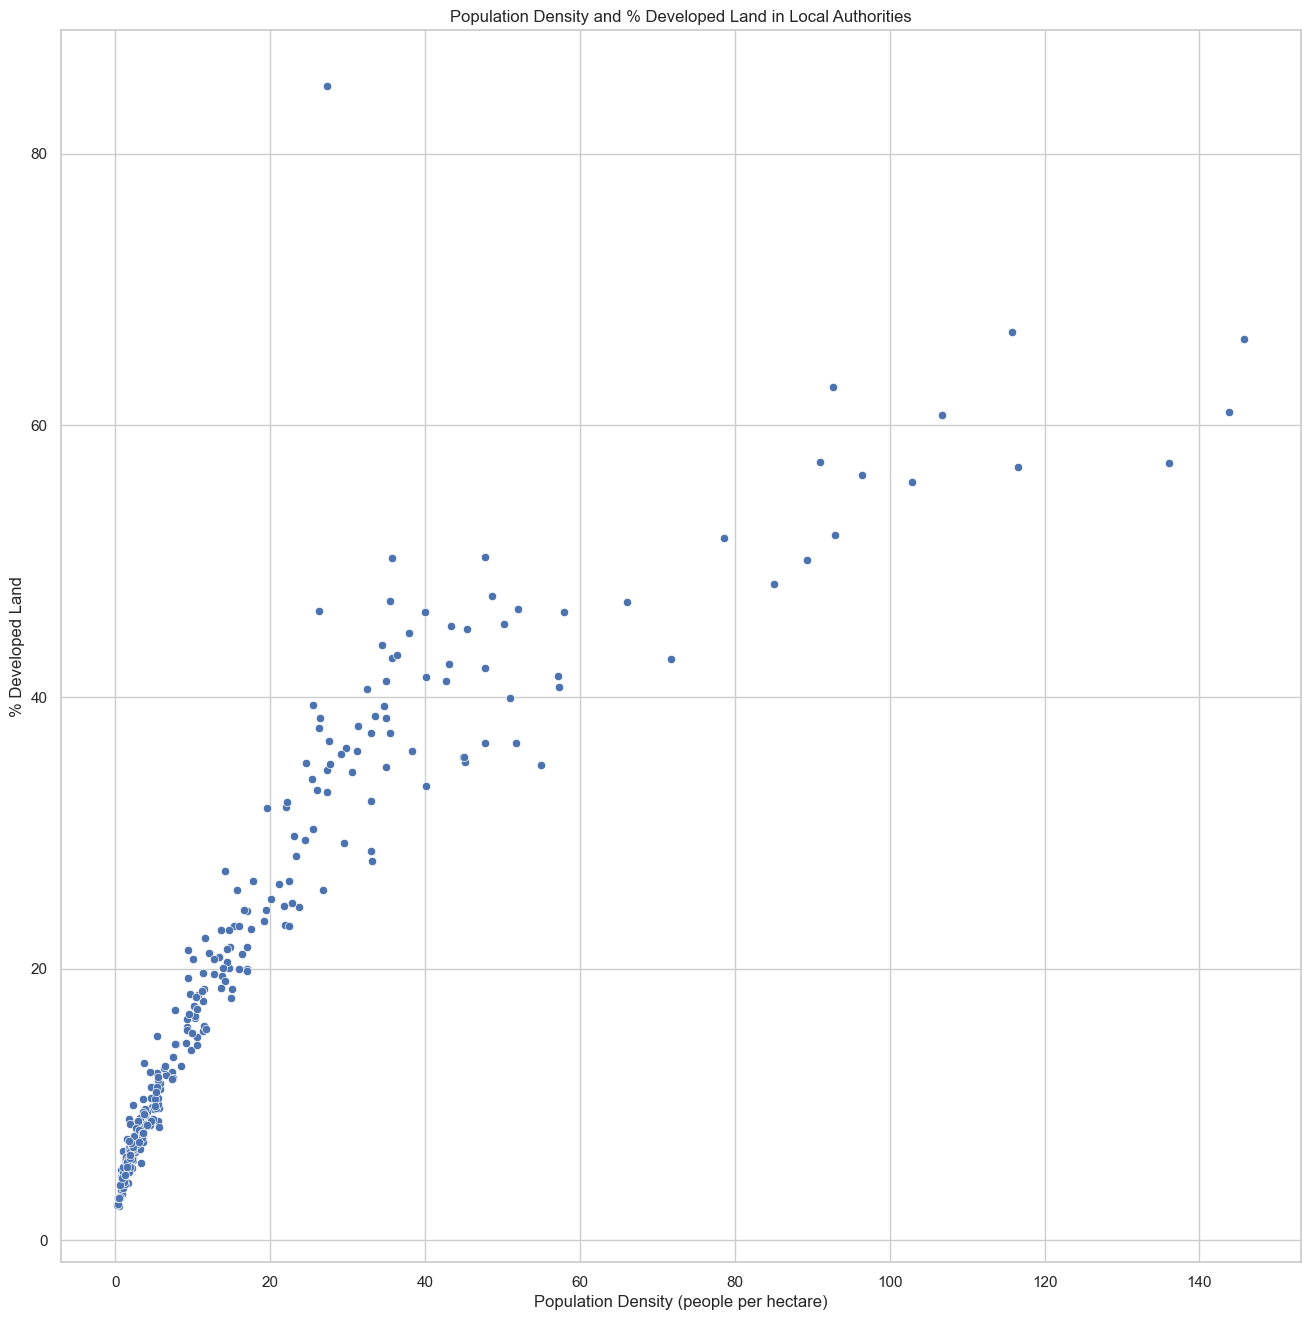

In [36]:
#Reset the chart plot size
sns.set(rc={"figure.figsize":(16, 16)},
        style='whitegrid')

sns.scatterplot(data=combined_df, x="Population Density (people per hectare)", y="% Developed Land").set(title='Population Density and % Developed Land in Local Authorities');

The scatterplot shows an overall fairly strong positive correlation between population density and the proportion of developed land. There is one outlier with over 80% developed land but a lower population density than might be expected. I am going to find out what this LA is.

In [37]:
#Identify outlier in scatterplots of population density and proportion of developed land
outlier = combined_df.loc[(combined_df['% Developed Land'] >= 80) ]
outlier

ONS Code Local Authority Name  Total Land Area (hectares)  \
56  E09000001       City of London                  314.938269   

    % Developed Land  Proportion pop aged 0-34  All persons  \
56             84.96                 47.674419         8600   

    Population Density (people per hectare)  
56                                27.306939

The  fact that the outlier is the City of London makes sense as this area has a very high proportion of developed land with office blocks etc but relatively few people live there compared to other areas of London.  

There do seem to be some clusters visible on the scatterplot. I would like to see whether the proportion of the population under 35 correlates with population density so I will produce a scatterplot to check this.

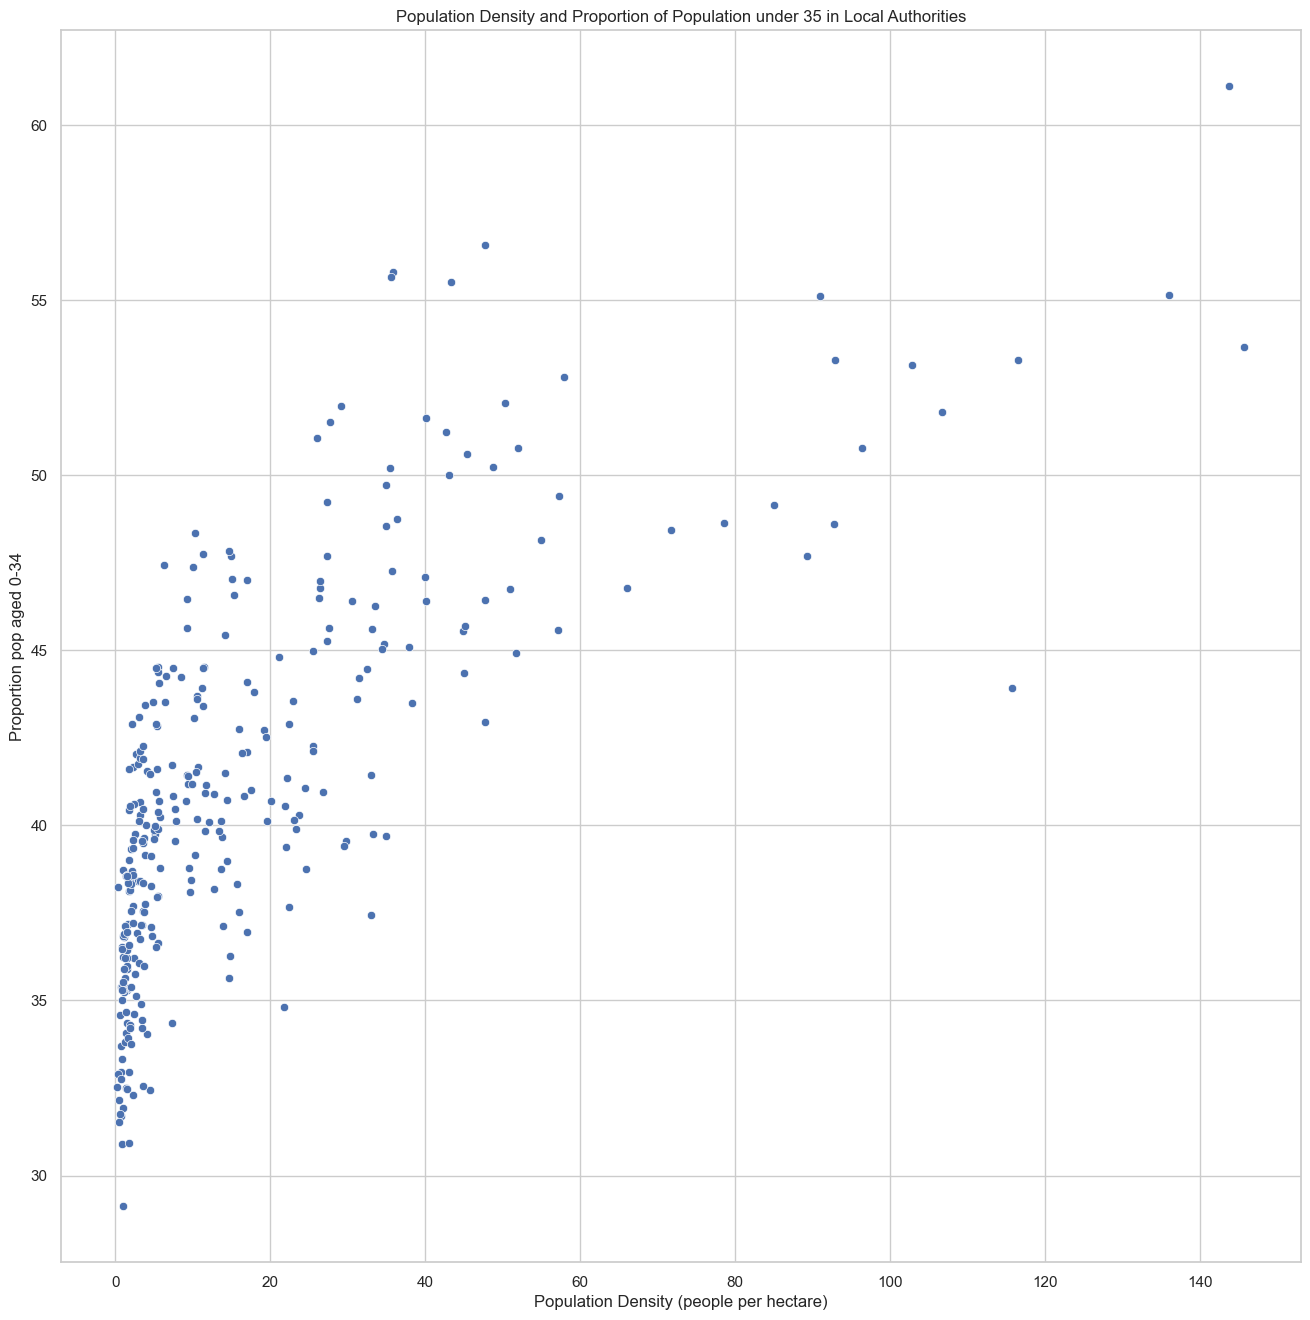

In [38]:
#Reset the chart plot size
sns.set(rc={"figure.figsize":(16, 16)},
        style='whitegrid')

sns.scatterplot(data=combined_df, x="Population Density (people per hectare)", y="Proportion pop aged 0-34").set(title='Population Density and Proportion of Population under 35 in Local Authorities');

It appears to correlate but I will also check using Pearson's R correlation coefficient.

In [39]:
#Pearson's R correlation coefficient
(r, p) = scipy.stats.pearsonr(combined_df['Population Density (people per hectare)'],
                              combined_df['Proportion pop aged 0-34'])

print('r: {r}, p: {p}'.format(r=r, p=p))

r: 0.7243610651560741, p: 1.6274380452504376e-51


There does appear to be fairly strong correlation at 0.724. Now I will check whether the proportion of the population under 35 correlates with the proportion of developed land so I will produce a scatterplot to check this.

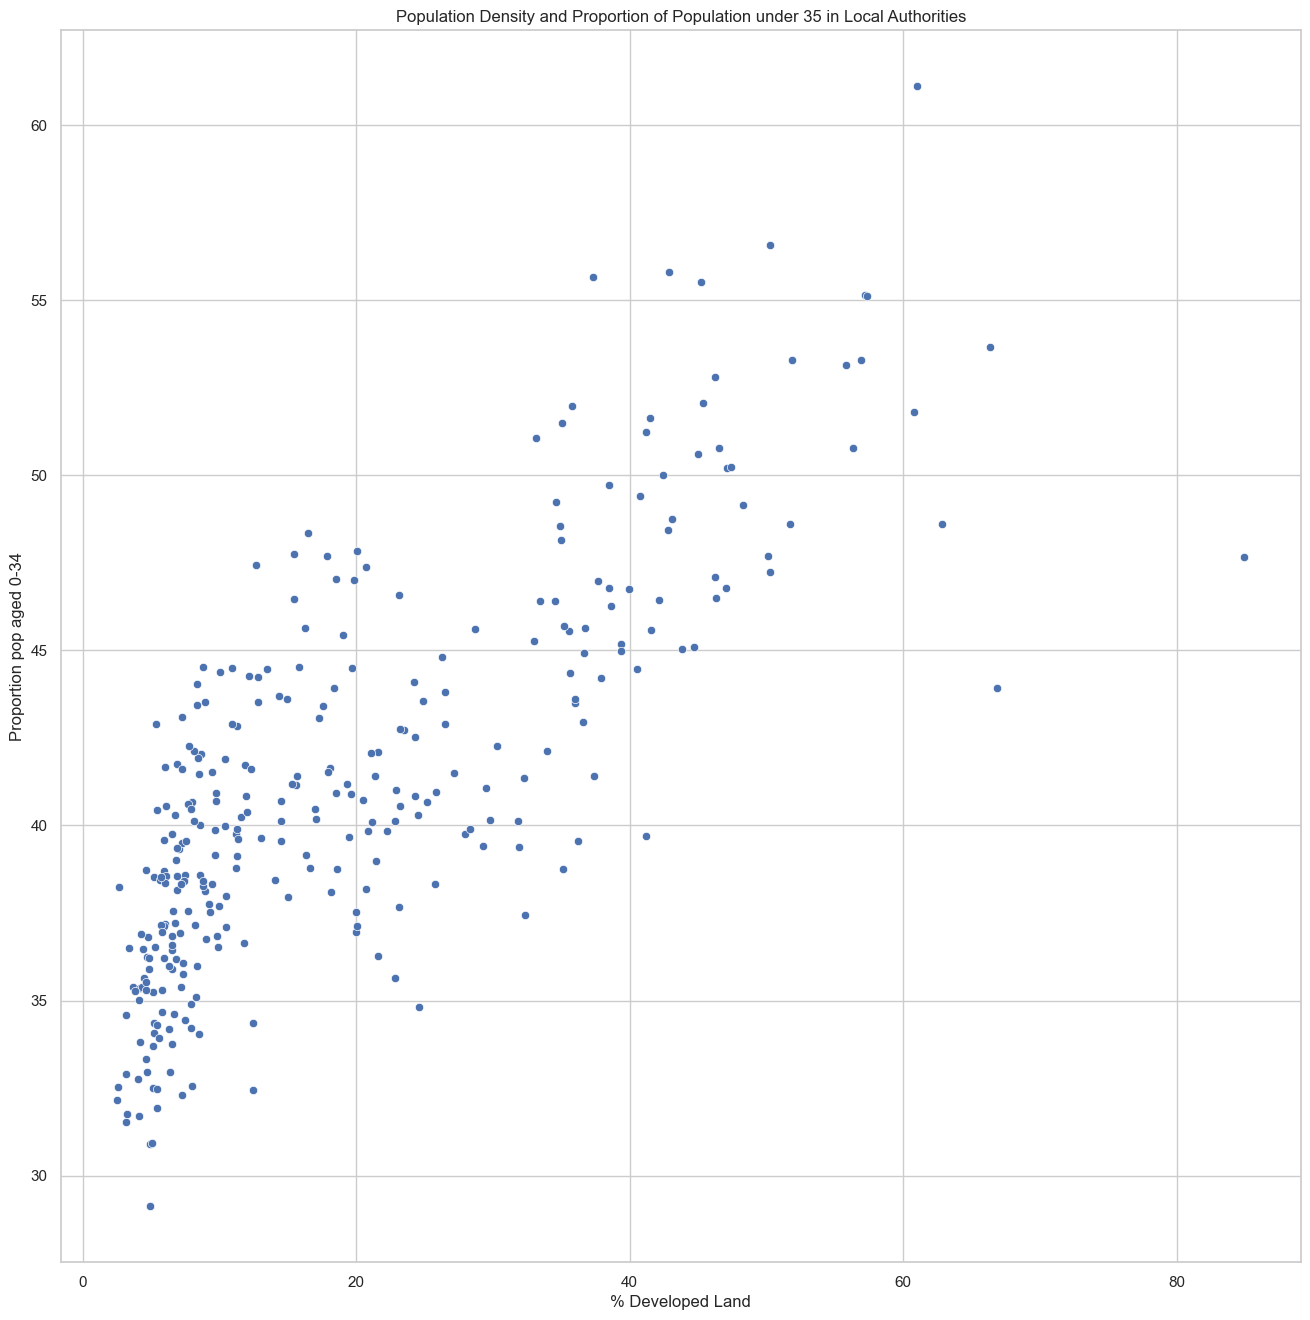

In [40]:
#Reset the chart plot size
sns.set(rc={"figure.figsize":(16, 16)},
        style='whitegrid')

sns.scatterplot(data=combined_df, x="% Developed Land", y="Proportion pop aged 0-34").set(title ='Population Density and Proportion of Population under 35 in Local Authorities');

Again it seems to correlate but I will check calculating the correlation coefficient.

In [41]:
#Pearson's R correlation coefficient
(r, p) = scipy.stats.pearsonr(combined_df['% Developed Land'],
                              combined_df['Proportion pop aged 0-34'])

print('r: {r}, p: {p}'.format(r=r, p=p))

r: 0.7824573582715375, p: 4.05672284260325e-65


This has a fairly high positive correlation of 0.78. Now  I would like to use the k-means clustering algorithm to cluster the LAs into groups depending on their degree of urbanisation. I will try using various numbers for k.

In [42]:
# Create an instance of the clusterer with k=4
kmeans4 = cluster.KMeans(n_clusters=4, n_init=10)

clustering_df = combined_df[["% Developed Land", "Population Density (people per hectare)", "Local Authority Name"]]
clustering_df.set_index('Local Authority Name', inplace = True)
clustering_df.head()

% Developed Land  \
Local Authority Name                     
Adur                             21.57   
Allerdale                         3.67   
Amber Valley                      9.82   
Arun                             12.43   
Ashfield                         18.52   

                      Population Density (people per hectare)  
Local Authority Name                                           
Adur                                                14.778306  
Allerdale                                            0.727728  
Amber Valley                                         4.754430  
Arun                                                 7.340612  
Ashfield                                            11.528409

In [43]:
# Call the fit function on the clusterer to fit the data to the 4 means.
assignedClusters_clust = kmeans4.fit(clustering_df)


combined_df['4means_cluster'] = assignedClusters_clust.labels_
combined_df.head()

ONS Code Local Authority Name  Total Land Area (hectares)  \
0  E07000223                 Adur                 4364.505691   
1  E07000026            Allerdale               132054.795869   
2  E07000032         Amber Valley                26543.663279   
3  E07000224                 Arun                22450.444783   
4  E07000170             Ashfield                10955.544524   

   % Developed Land  Proportion pop aged 0-34  All persons  \
0             21.57                 36.279070        64500   
1              3.67                 35.379813        96100   
2              9.82                 36.846276       126200   
3             12.43                 34.344660       164800   
4             18.52                 40.934283       126300   

   Population Density (people per hectare)  4means_cluster  
0                                14.778306               2  
1                                 0.727728               0  
2                                 4.754430               0  
3                                 7.340612               0  
4                                11.528409               2

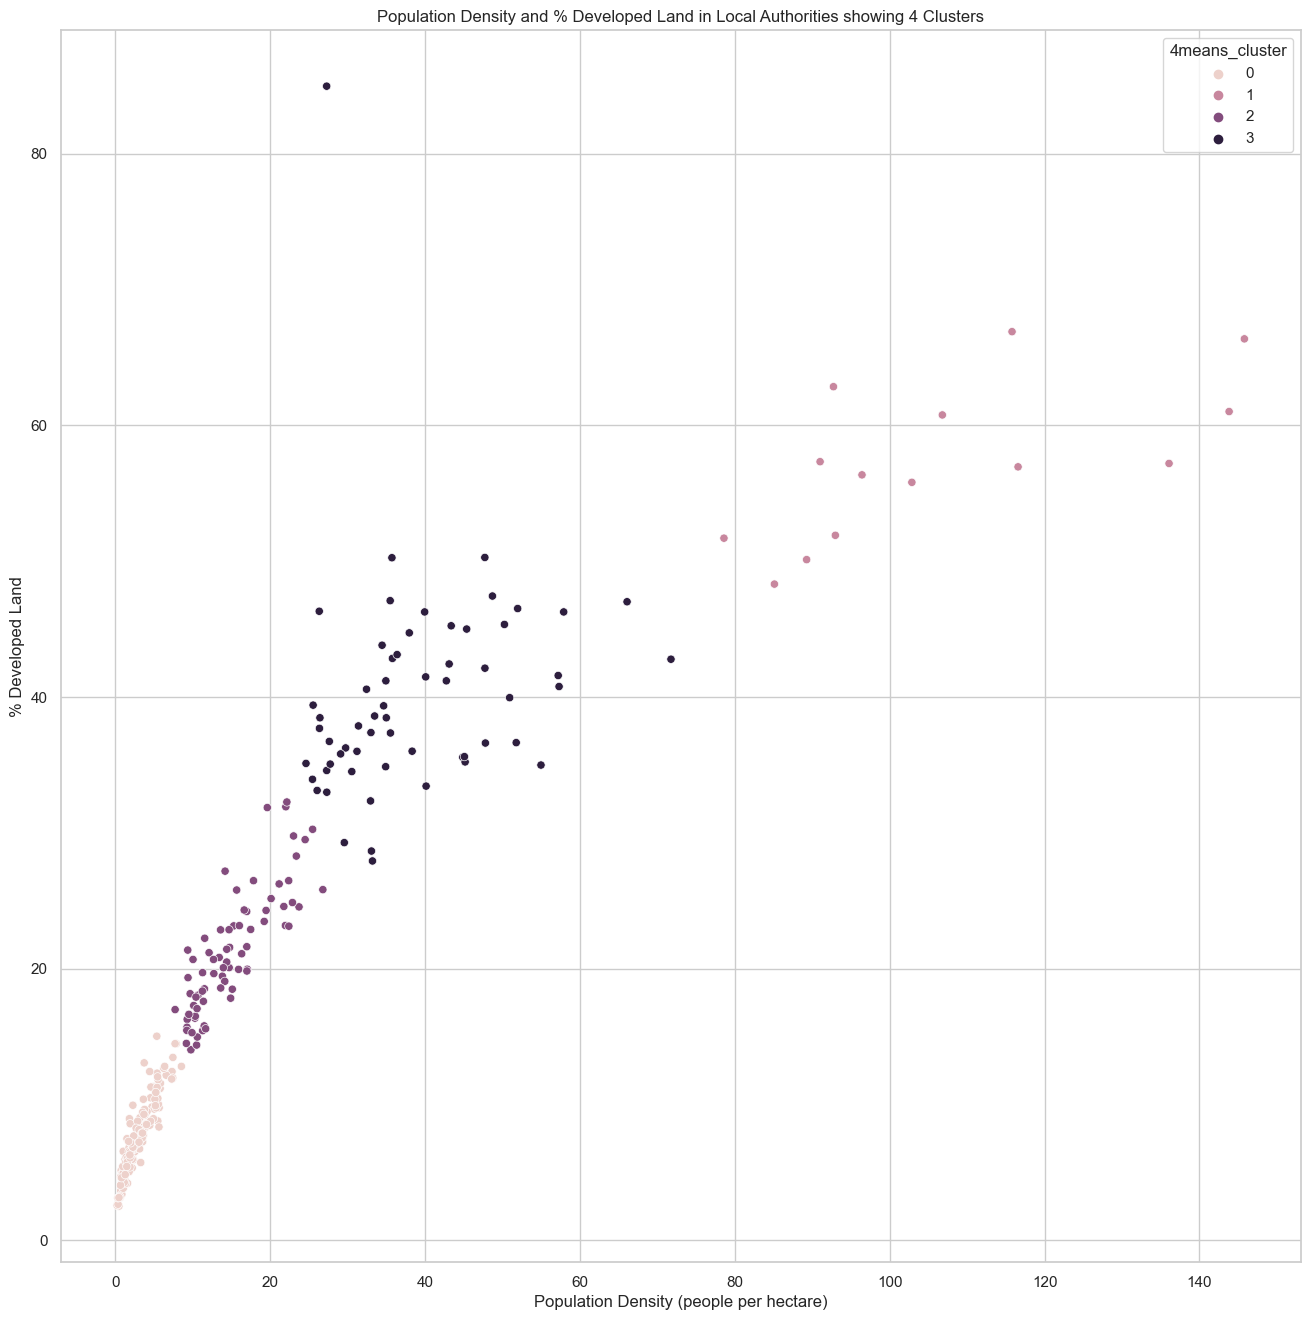

In [44]:
#Reset the chart plot size
sns.set(rc={"figure.figsize":(16, 16)},
        style='whitegrid')

sns.scatterplot(data=combined_df, x="Population Density (people per hectare)", y="% Developed Land", hue = "4means_cluster").set(title='Population Density and % Developed Land in Local Authorities showing 4 Clusters');

The diagram shows that a cluster of 4 might be appropriate for the data. I will now calculate the silhouette statistics to generate a silhouette plot to check its suitability.

In [45]:
# Add the silhouette coefficients as a new column in the
# combined DataFrame:
combined_df["4silhouette"] = silhouette_samples(
    combined_df[["Population Density (people per hectare)", "% Developed Land"]],
    combined_df["4means_cluster"])

combined_df.head()

ONS Code Local Authority Name  Total Land Area (hectares)  \
0  E07000223                 Adur                 4364.505691   
1  E07000026            Allerdale               132054.795869   
2  E07000032         Amber Valley                26543.663279   
3  E07000224                 Arun                22450.444783   
4  E07000170             Ashfield                10955.544524   

   % Developed Land  Proportion pop aged 0-34  All persons  \
0             21.57                 36.279070        64500   
1              3.67                 35.379813        96100   
2              9.82                 36.846276       126200   
3             12.43                 34.344660       164800   
4             18.52                 40.934283       126300   

   Population Density (people per hectare)  4means_cluster  4silhouette  
0                                14.778306               2     0.684705  
1                                 0.727728               0     0.798607  
2                                 4.754430               0     0.743754  
3                                 7.340612               0     0.424257  
4                                11.528409               2     0.546599

In [46]:
#Create new df and sort it to produce silhouette plot
combined_df_sorted = combined_df.sort_values(["4means_cluster", "4silhouette"])

# Reset the index
combined_df_sorted.reset_index(drop=True, inplace=True)

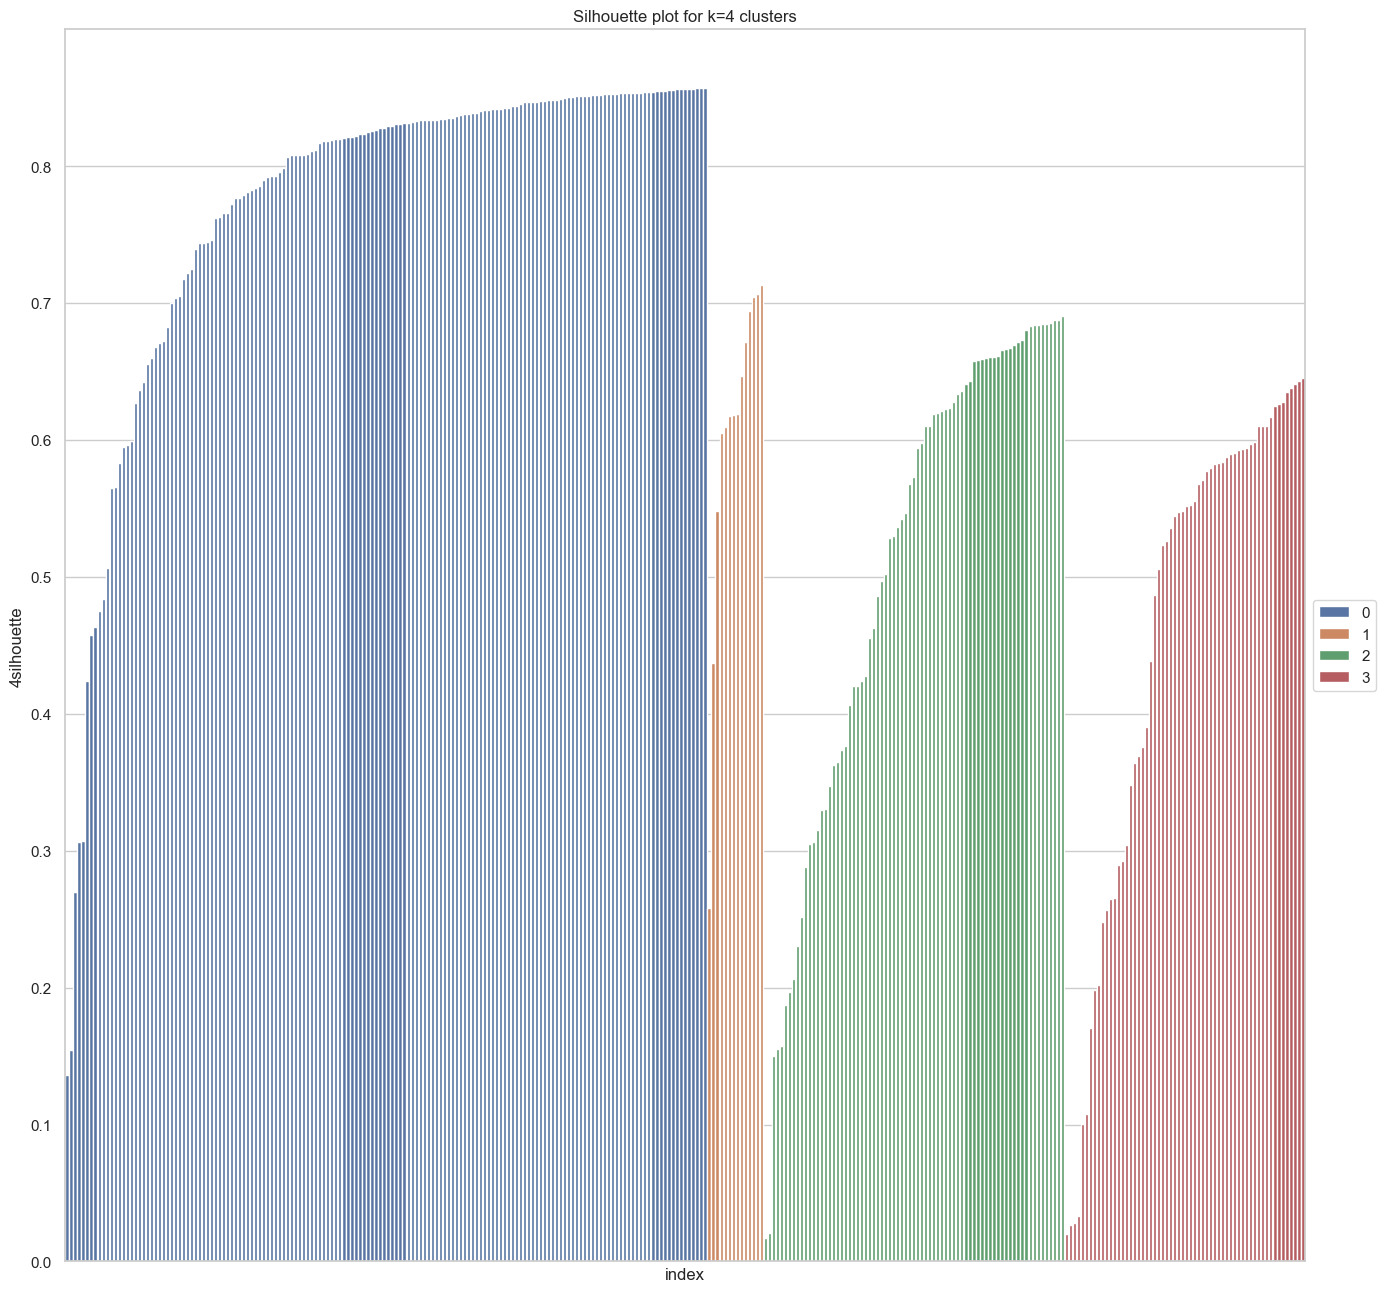

In [47]:
#Produce silhouette plot for k=4 clusters
ax = sns.barplot(data=combined_df_sorted.reset_index(),
                 x="index",
                 y="4silhouette",
                 hue="4means_cluster",
                 # The dodge=False parameter has a useful side effect of thickening the bars
                 dodge=False)

#Suppress the x-axis tick labels
ax.set(xticks=[],
       title="Silhouette plot for k=4 clusters")

#Pop the legend out the the main plot frame
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

That looks suitable as all values are positive.Now I will look at k=3 and k=5.

In [48]:
# Create an instance of the clusterer with k=3
kmeans3 = cluster.KMeans(n_clusters=3, n_init=10)

clustering_df = combined_df[["% Developed Land", "Population Density (people per hectare)", "Local Authority Name"]]
clustering_df.set_index('Local Authority Name', inplace = True)
clustering_df.head()

# Call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clustering_df)


combined_df['3means_cluster'] = assignedClusters_clust.labels_
combined_df.head()

ONS Code Local Authority Name  Total Land Area (hectares)  \
0  E07000223                 Adur                 4364.505691   
1  E07000026            Allerdale               132054.795869   
2  E07000032         Amber Valley                26543.663279   
3  E07000224                 Arun                22450.444783   
4  E07000170             Ashfield                10955.544524   

   % Developed Land  Proportion pop aged 0-34  All persons  \
0             21.57                 36.279070        64500   
1              3.67                 35.379813        96100   
2              9.82                 36.846276       126200   
3             12.43                 34.344660       164800   
4             18.52                 40.934283       126300   

   Population Density (people per hectare)  4means_cluster  4silhouette  \
0                                14.778306               2     0.684705   
1                                 0.727728               0     0.798607   
2                                 4.754430               0     0.743754   
3                                 7.340612               0     0.424257   
4                                11.528409               2     0.546599   

   3means_cluster  
0               0  
1               0  
2               0  
3               0  
4               0

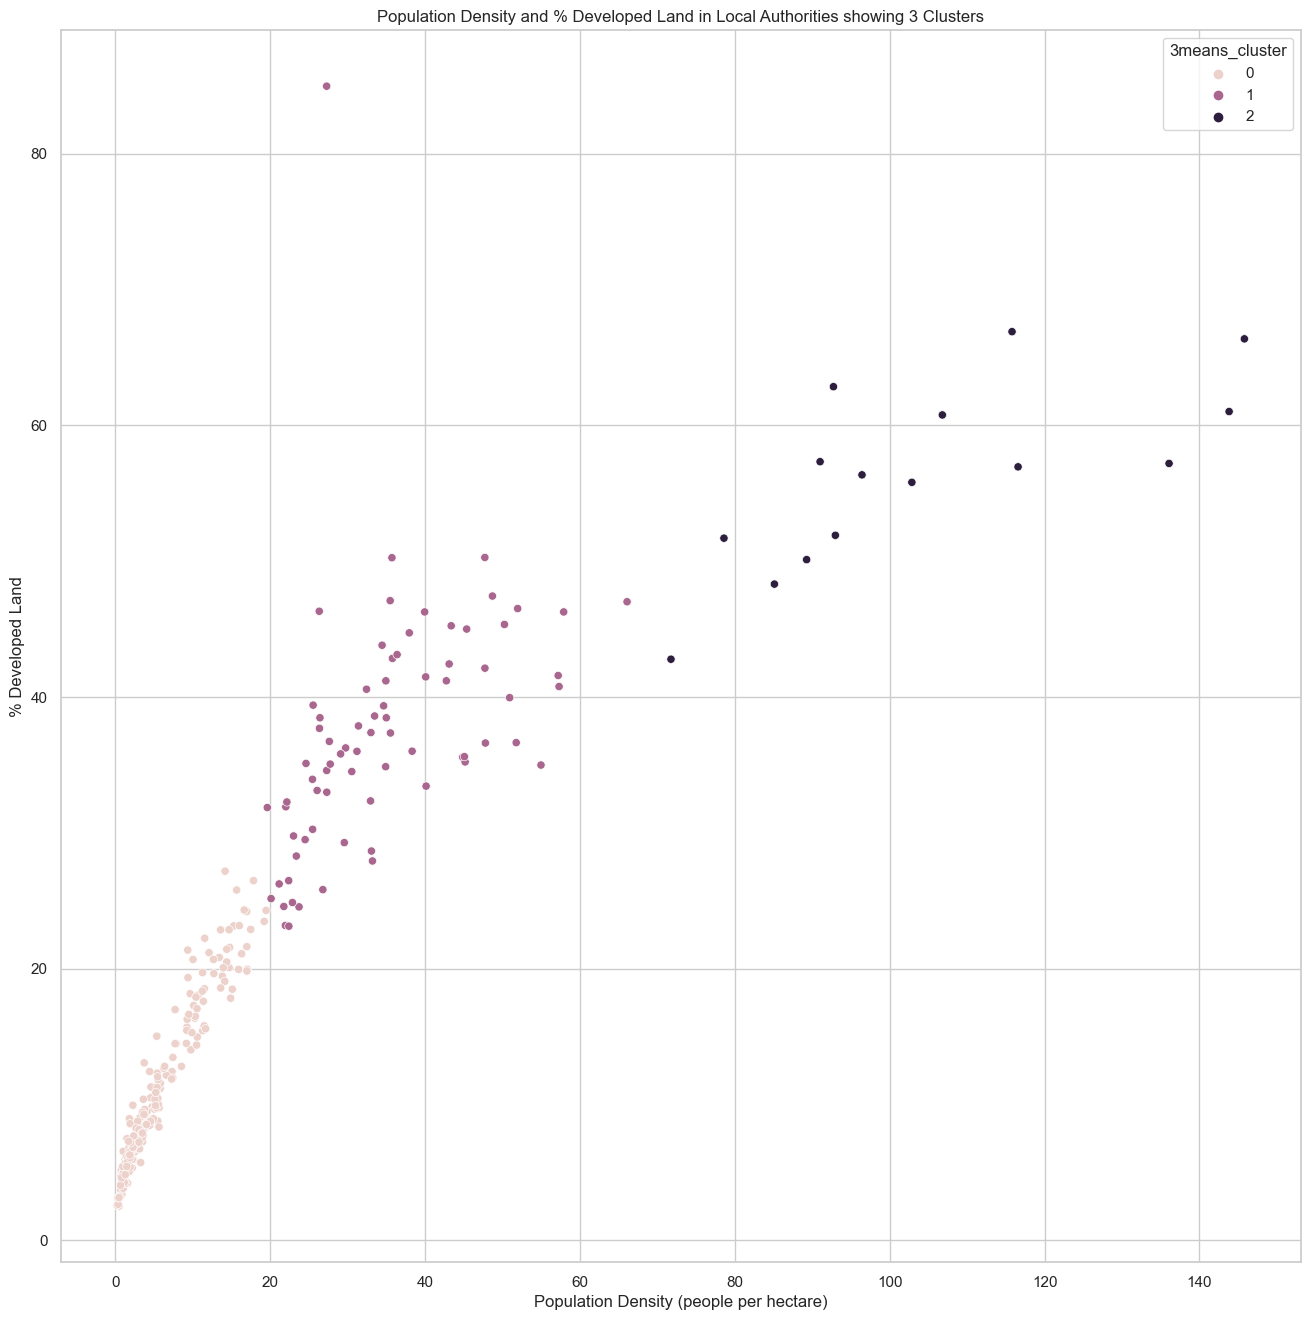

In [49]:
#Reset the chart plot size
sns.set(rc={"figure.figsize":(16, 16)},
        style='whitegrid')

sns.scatterplot(data=combined_df, x="Population Density (people per hectare)", y="% Developed Land", hue = "3means_cluster").set(title='Population Density and % Developed Land in Local Authorities showing 3 Clusters');

In [50]:
# Add the silhouette coefficients as a new column in the
# combined DataFrame:
combined_df["3silhouette"] = silhouette_samples(
    combined_df[["Population Density (people per hectare)", "% Developed Land"]],
    combined_df["3means_cluster"])

combined_df.head()

ONS Code Local Authority Name  Total Land Area (hectares)  \
0  E07000223                 Adur                 4364.505691   
1  E07000026            Allerdale               132054.795869   
2  E07000032         Amber Valley                26543.663279   
3  E07000224                 Arun                22450.444783   
4  E07000170             Ashfield                10955.544524   

   % Developed Land  Proportion pop aged 0-34  All persons  \
0             21.57                 36.279070        64500   
1              3.67                 35.379813        96100   
2              9.82                 36.846276       126200   
3             12.43                 34.344660       164800   
4             18.52                 40.934283       126300   

   Population Density (people per hectare)  4means_cluster  4silhouette  \
0                                14.778306               2     0.684705   
1                                 0.727728               0     0.798607   
2                                 4.754430               0     0.743754   
3                                 7.340612               0     0.424257   
4                                11.528409               2     0.546599   

   3means_cluster  3silhouette  
0               0     0.437037  
1               0     0.818459  
2               0     0.845853  
3               0     0.801593  
4               0     0.627923

In [51]:
#Create new df and sort it to produce silhouette plot
combined_df_sorted = combined_df.sort_values(["3means_cluster", "3silhouette"])

# Reset the index
combined_df_sorted.reset_index(drop=True, inplace=True)

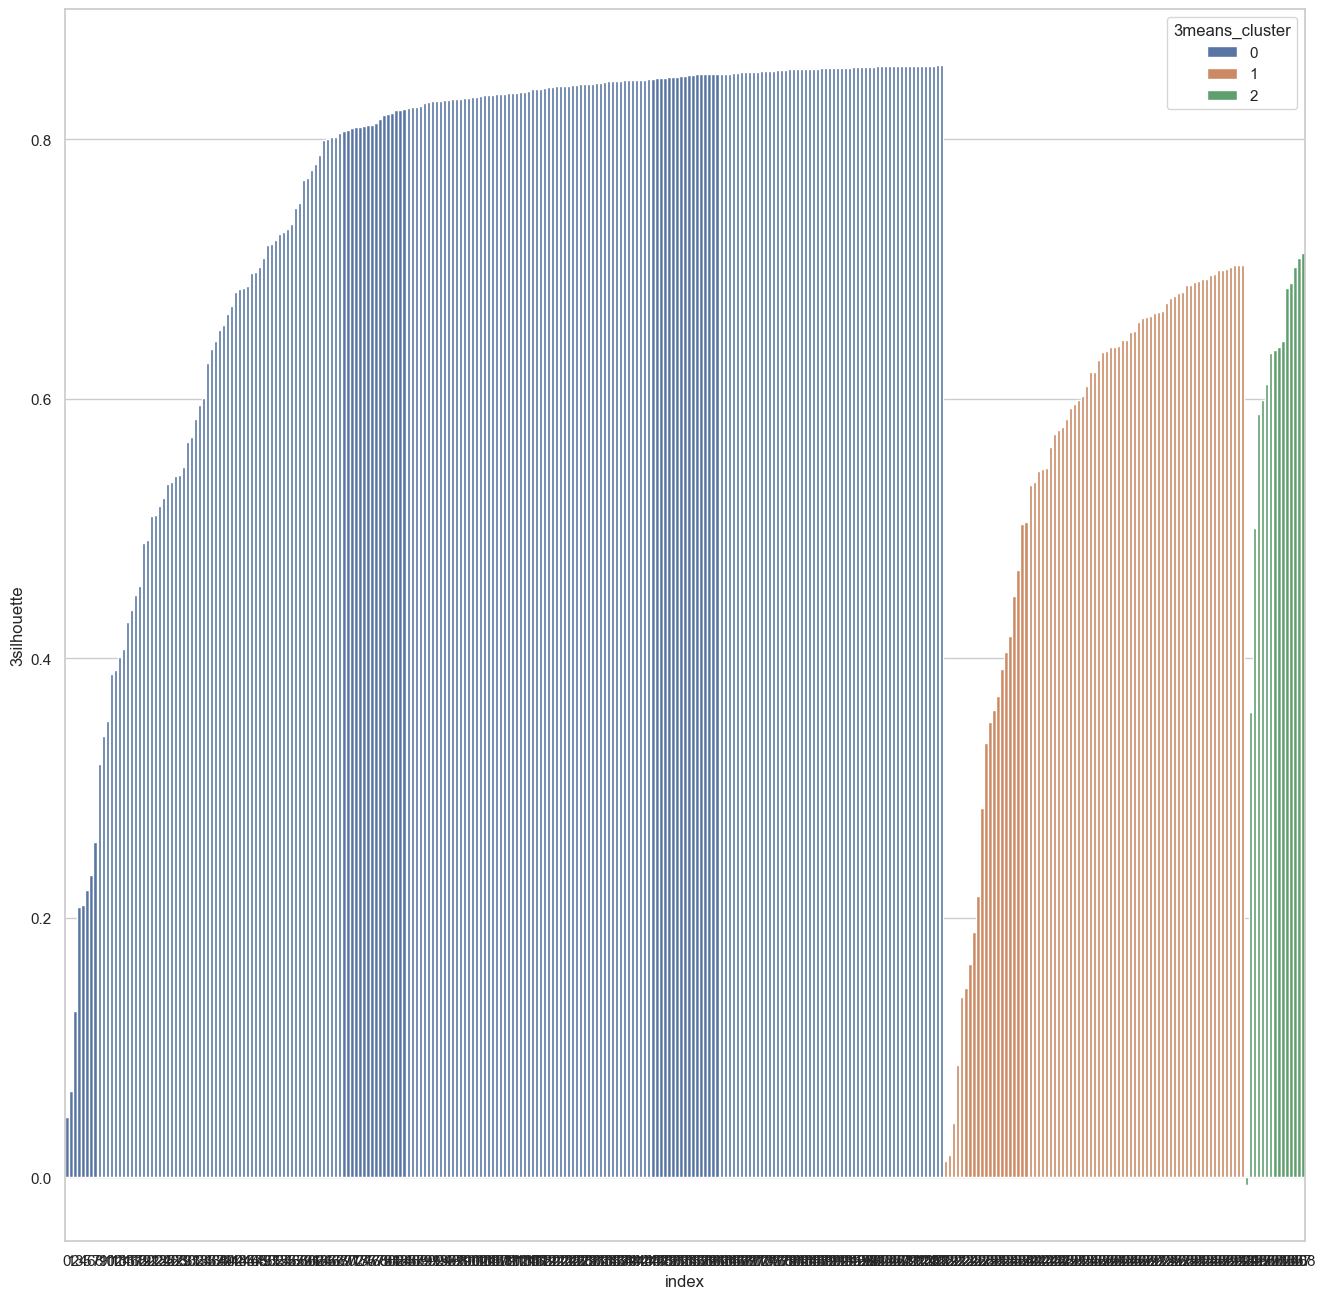

In [52]:
#Produce silhouette plot for k=3 clusters
x = sns.barplot(data=combined_df_sorted.reset_index(),
                 x="index",
                 y="3silhouette",
                 hue="3means_cluster",
                 # The dodge=False parameter has a useful side effect of thickening the bars
                 dodge=False)

#Suppress the x-axis tick labels
ax.set(xticks=[],
       title="Silhouette plot for k=3 clusters")

#Pop the legend out the the main plot frame
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

In [53]:
# Create an instance of the clusterer with k=5
kmeans5 = cluster.KMeans(n_clusters=5, n_init=10)

clustering_df = combined_df[["% Developed Land", "Population Density (people per hectare)", "Local Authority Name"]]
clustering_df.set_index('Local Authority Name', inplace = True)
clustering_df.head()

# Call the fit function on the clusterer to fit the data to the 5 means.
assignedClusters_clust = kmeans5.fit(clustering_df)


combined_df['5means_cluster'] = assignedClusters_clust.labels_
combined_df.head()

ONS Code Local Authority Name  Total Land Area (hectares)  \
0  E07000223                 Adur                 4364.505691   
1  E07000026            Allerdale               132054.795869   
2  E07000032         Amber Valley                26543.663279   
3  E07000224                 Arun                22450.444783   
4  E07000170             Ashfield                10955.544524   

   % Developed Land  Proportion pop aged 0-34  All persons  \
0             21.57                 36.279070        64500   
1              3.67                 35.379813        96100   
2              9.82                 36.846276       126200   
3             12.43                 34.344660       164800   
4             18.52                 40.934283       126300   

   Population Density (people per hectare)  4means_cluster  4silhouette  \
0                                14.778306               2     0.684705   
1                                 0.727728               0     0.798607   
2                                 4.754430               0     0.743754   
3                                 7.340612               0     0.424257   
4                                11.528409               2     0.546599   

   3means_cluster  3silhouette  5means_cluster  
0               0     0.437037               0  
1               0     0.818459               3  
2               0     0.845853               3  
3               0     0.801593               3  
4               0     0.627923               0

In [54]:
# Add the silhouette coefficients as a new column in the
# combined DataFrame:
combined_df["5silhouette"] = silhouette_samples(
    combined_df[["Population Density (people per hectare)", "% Developed Land"]],
    combined_df["5means_cluster"])

combined_df.head()

ONS Code Local Authority Name  Total Land Area (hectares)  \
0  E07000223                 Adur                 4364.505691   
1  E07000026            Allerdale               132054.795869   
2  E07000032         Amber Valley                26543.663279   
3  E07000224                 Arun                22450.444783   
4  E07000170             Ashfield                10955.544524   

   % Developed Land  Proportion pop aged 0-34  All persons  \
0             21.57                 36.279070        64500   
1              3.67                 35.379813        96100   
2              9.82                 36.846276       126200   
3             12.43                 34.344660       164800   
4             18.52                 40.934283       126300   

   Population Density (people per hectare)  4means_cluster  4silhouette  \
0                                14.778306               2     0.684705   
1                                 0.727728               0     0.798607   
2                                 4.754430               0     0.743754   
3                                 7.340612               0     0.424257   
4                                11.528409               2     0.546599   

   3means_cluster  3silhouette  5means_cluster  5silhouette  
0               0     0.437037               0     0.684705  
1               0     0.818459               3     0.798607  
2               0     0.845853               3     0.743754  
3               0     0.801593               3     0.424257  
4               0     0.627923               0     0.546599

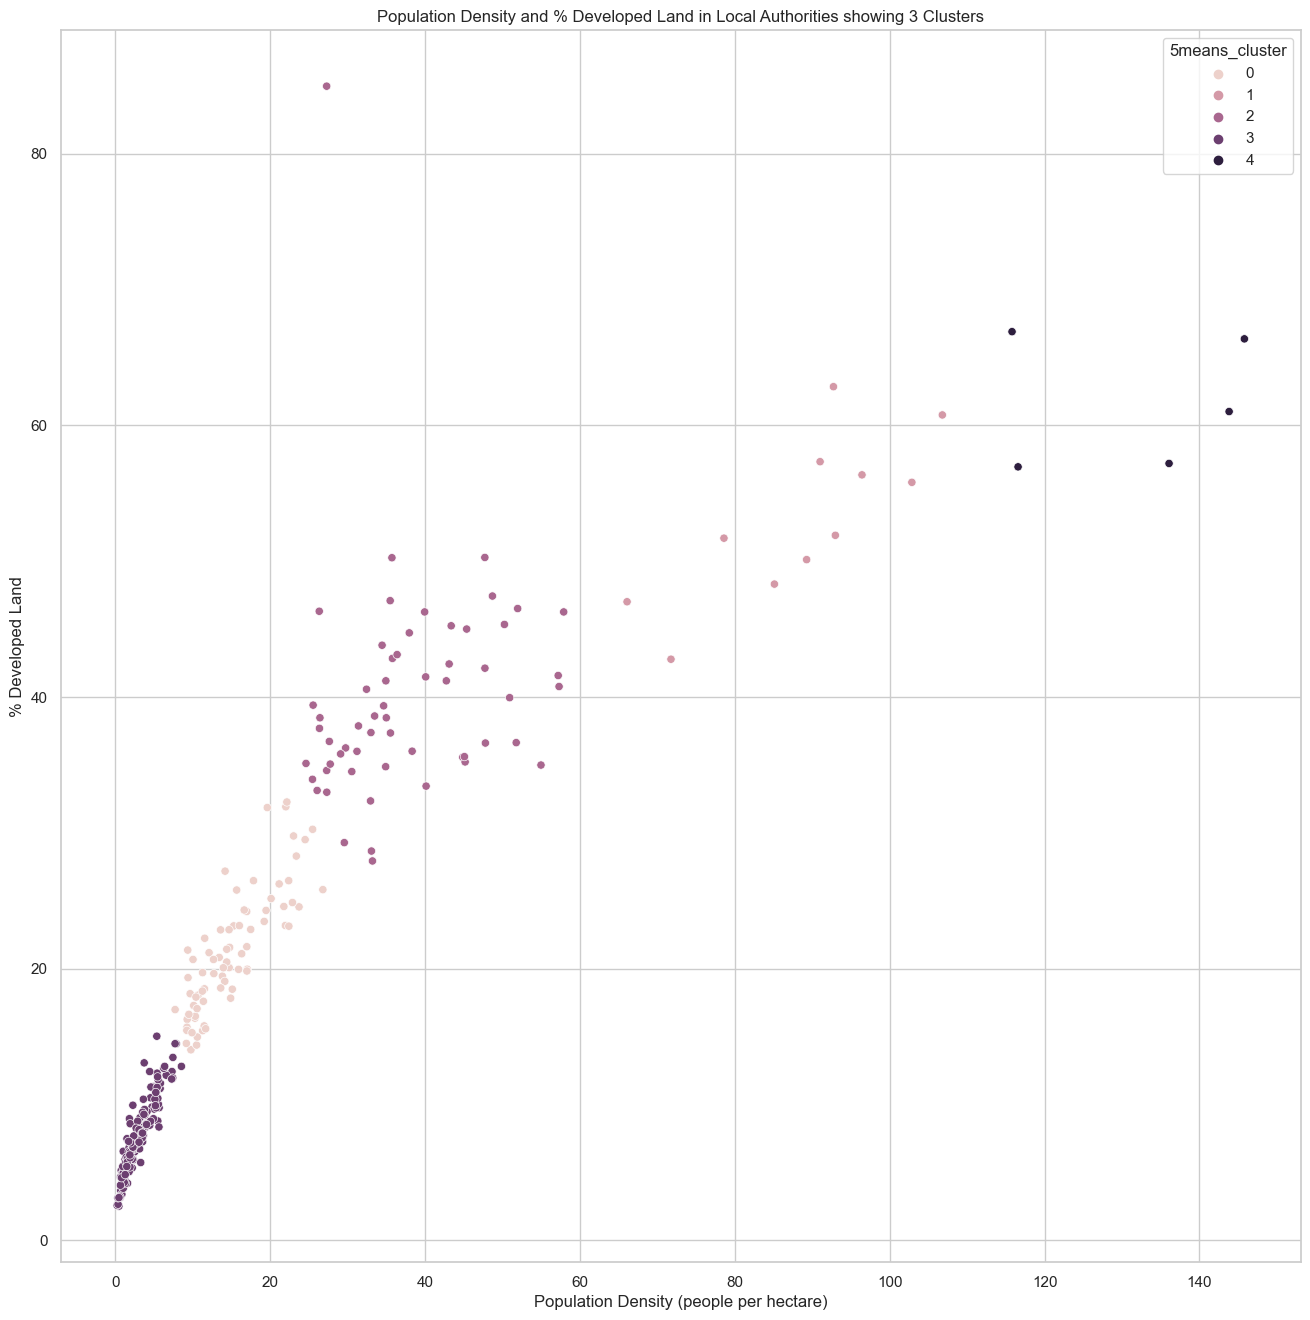

In [55]:
#Reset the chart plot size
sns.set(rc={"figure.figsize":(16, 16)},
        style='whitegrid')

sns.scatterplot(data=combined_df, x="Population Density (people per hectare)", y="% Developed Land", hue = "5means_cluster").set(title='Population Density and % Developed Land in Local Authorities showing 3 Clusters');

In [56]:
#Create new df and sort it to produce silhouette plot
combined_df_sorted = combined_df.sort_values(["5means_cluster", "5silhouette"])

# Reset the index
combined_df_sorted.reset_index(drop=True, inplace=True)

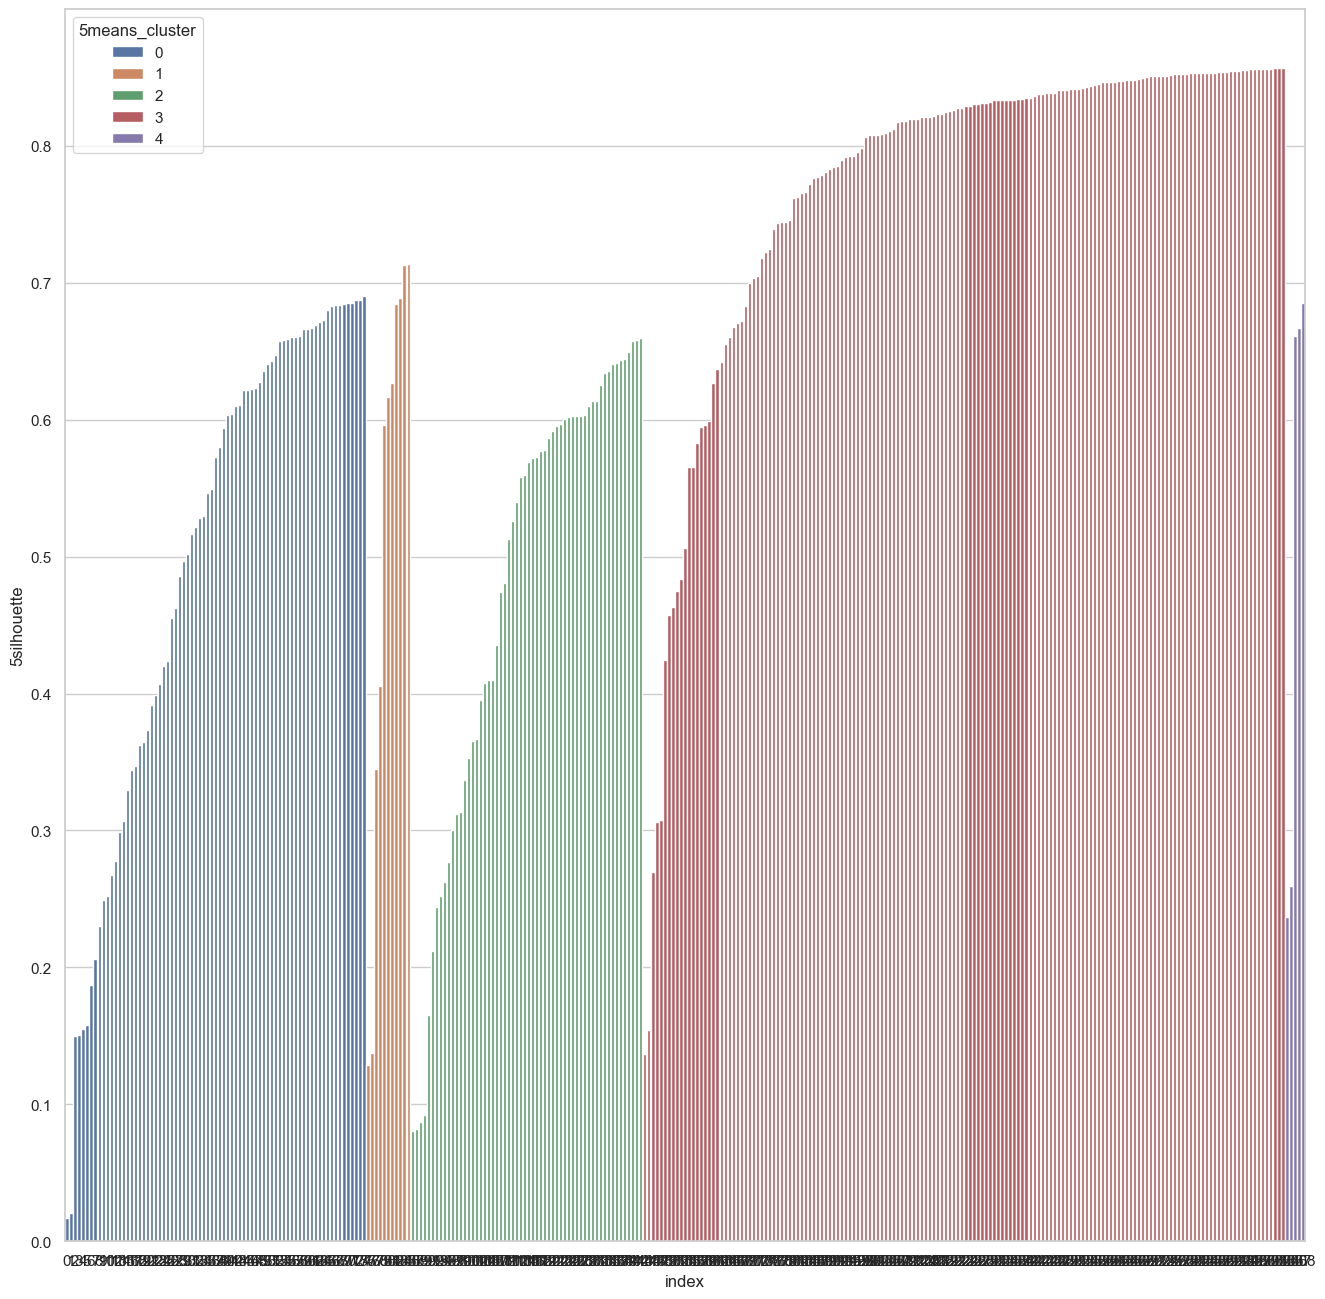

In [57]:
#Produce silhouette plot for k=3 clusters
x = sns.barplot(data=combined_df_sorted.reset_index(),
                 x="index",
                 y="5silhouette",
                 hue="5means_cluster",
                 # The dodge=False parameter has a useful side effect of thickening the bars
                 dodge=False)

#Suppress the x-axis tick labels
ax.set(xticks=[],
       title="Silhouette plot for k=5 clusters")

#Pop the legend out the the main plot frame
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

Now I will calculate the mean silhouette statistics to see which cluster works well.

In [58]:
#Calculate mean silhouette statistics for k=3
total3silo = combined_df['3silhouette'].sum()
mean_silo_3 = total3silo/len(combined_df.index)
print('Mean silhouette statistic for 3 clusters is',mean_silo_3)

#Calculate mean silhouette statistics for k=4
total4silo = combined_df['4silhouette'].sum()
mean_silo_4 = total4silo/len(combined_df.index)
print('Mean silhouette statistic for 4 clusters is',mean_silo_4)

#Calculate mean silhouette statistics for k=5
total5silo = combined_df['5silhouette'].sum()
mean_silo_5 = total5silo/len(combined_df.index)
print('Mean silhouette statistic for 5 clusters is',mean_silo_5)

Mean silhouette statistic for 3 clusters is 0.6946525447756988
Mean silhouette statistic for 4 clusters is 0.6377568217123043
Mean silhouette statistic for 5 clusters is 0.636503598970922


While 3 clusters has the highest mean silhouette statistic and the clustering looks suitable however in three clusters the vast majority of Local Authorities have been clustered into one group so it does not differentiate sufficiently between the LAs with the lowest proportion of developed land use and population density which were the vast majority of LAs.  Therefore I am going to use four clusters which has the second highest mean silhouette statistic. Five clusters has a very similar mean silhouette statistic but it has two clusters with very few Local Authorities in them.

In order to check whether more urbanised areas do have a larger proportion of their population under 35 I am going to divide each LA into a category according to whether they have a proportion of 35 years old above or equal to the average or below the average. First I need to calculate the average.

In [59]:
#Calculate average proportion of 0-34 year olds
sum_prop_under_35 =  combined_df['Proportion pop aged 0-34'].sum()
mean_prop_under_35 = sum_prop_under_35/len(combined_df.index)
print('Average proportion of under 35s is', mean_prop_under_35) 

Average proportion of under 35s is 41.11009398543328


Now I will assign the category of above (and equal to) or below average proportion of population under 35.

In [60]:
#Assign category (above or below average) based on proportion of population under 35 
combined_df['Above/below average proportion of pop aged 0-34'] = np.where(combined_df['Proportion pop aged 0-34'] >= mean_prop_under_35, "Above", "Below")
combined_df

ONS Code                 Local Authority Name  \
0    E07000223                                 Adur   
1    E07000026                            Allerdale   
2    E07000032                         Amber Valley   
3    E07000224                                 Arun   
4    E07000170                             Ashfield   
..         ...                                  ...   
304  E07000245                         West Suffolk   
305  E06000060                      Buckinghamshire   
306  E06000058  Bournemouth, Christchurch and Poole   
307  E06000059                               Dorset   
308  E07000246            Somerset West and Taunton   

     Total Land Area (hectares)  % Developed Land  Proportion pop aged 0-34  \
0                   4364.505691             21.57                 36.279070   
1                 132054.795869              3.67                 35.379813   
2                  26543.663279              9.82                 36.846276   
3                  22450.444783             12.43                 34.344660   
4                  10955.544524             18.52                 40.934283   
..                          ...               ...                       ...   
304               103448.896657              7.29                 41.601780   
305               156488.645695              7.90                 40.462846   
306                17379.276560             29.77                 40.144891   
307               252036.384802              5.44                 32.481560   
308               121005.325243              4.84                 36.213469   

     All persons  Population Density (people per hectare)  4means_cluster  \
0          64500                                14.778306               2   
1          96100                                 0.727728               0   
2         126200                                 4.754430               0   
3         164800                                 7.340612               0   
4         126300                                11.528409               2   
..           ...                                      ...             ...   
304       179800                                 1.738056               0   
305       553100                                 3.534442               0   
306       400300                                23.033180               2   
307       379600                                 1.506132               0   
308       157400                                 1.300769               0   

     4silhouette  3means_cluster  3silhouette  5means_cluster  5silhouette  \
0       0.684705               0     0.437037               0     0.684705   
1       0.798607               0     0.818459               3     0.798607   
2       0.743754               0     0.845853               3     0.743754   
3       0.424257               0     0.801593               3     0.424257   
4       0.546599               0     0.627923               0     0.546599   
..           ...             ...          ...             ...          ...   
304     0.848265               0     0.852561               3     0.848265   
305     0.833326               0     0.856627               3     0.833326   
306     0.376583               1     0.370722               0     0.344042   
307     0.846451               0     0.843853               3     0.846451   
308     0.834335               0     0.836869               3     0.834335   

    Above/below average proportion of pop aged 0-34  
0                                             Below  
1                                             Below  
2                                             Below  
3                                             Below  
4                                             Below  
..                                              ...  
304                                           Above  
305                                           Below  
306                                           Be

Now I want to produce a cross-tabulation of my results in order to perform a chi-squared test to check the null hypothesis that the proportion of under 35 year olds in an English LA is independent of how urbanised that LA is. 

In [61]:
#Cross tabulation contingency table
contingency = pd.crosstab(combined_df['4means_cluster'], combined_df['Above/below average proportion of pop aged 0-34'])
contingency 

Above/below average proportion of pop aged 0-34  Above  Below
4means_cluster                                               
0                                                   27    133
1                                                   14      0
2                                                   38     37
3                                                   54      6

Now to run the chi-squared test.

In [62]:
#Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)
print (f'Chi-square Statistic : {chi2} ,p-value: {p}')

Chi-square Statistic : 118.95815218087833 ,p-value: 1.2936252717544955e-25


The p-value is very small which offers some evidence against the null hypothesis that the degree of urbanisation and whether the proportion of the population aged 0-34 is above or below average are unrelated. So it looks like there may be a link between the proportion of under 35 year olds in an Local Authority and its level of urbanisation. 

Now I would like to produce three choropleth maps showing 1. Proportion of under 35 year olds in an LA. 2. Population density of an LA 3. Proportion of developed land in an LA, to see if the areas of higher proportion of under 35 year olds correlate with areas with higher population densities and higher proportions of developed land.

In [63]:
# Opening JSON file
f = open('Data/LA_2021_UK.geojson')
  
# returns JSON object as a dictionary
data = json.load(f)

# Closing file
f.close()


In [64]:
# Create our base map
EnglandMap = folium.Map(location = [52.1,-0.7599], zoom_start=6, max_zoom=10)



choropleth = folium.Choropleth(geo_data=data,
                                data=combined_df, 
                                columns=['ONS Code', 'Proportion pop aged 0-34'], 
                                key_on='feature.properties.LAD21CD',
                                fill_color='YlOrRd', fill_opacity=0.9, line_opacity=0.9,
                                nan_fill_color="transparent",
                                legend_name='Proportion of population aged 0-34',
                                threshold_scale=[0, 15, 30, 45, 60, 75])
                               

choropleth.add_to(EnglandMap)

EnglandMap

In [65]:
# Create our base map
EnglandMap2 = folium.Map(location = [52.1,-0.7599], zoom_start=6, max_zoom=7)



choropleth = folium.Choropleth(geo_data=data,
                                data=combined_df, 
                                columns=['ONS Code', 'Population Density (people per hectare)'], 
                                key_on='feature.properties.LAD21CD',
                                fill_color='RdYlBu', fill_opacity=0.8, line_opacity=0.9,
                                nan_fill_color="transparent",
                                legend_name='Population Density (average number of people per hectare)',
                                threshold_scale=[0, 15, 30, 45, 60, 150])
                               

choropleth.add_to(EnglandMap2)

EnglandMap2

In [66]:
# Create our base map
EnglandMap3 = folium.Map(location = [52.1,-0.7599], zoom_start=6, max_zoom=10)



choropleth = folium.Choropleth(geo_data=data,
                                data=combined_df, 
                                columns=['ONS Code', '% Developed Land'], 
                                key_on='feature.properties.LAD21CD',
                                fill_color='YlOrRd', fill_opacity=0.9, line_opacity=0.9,
                                nan_fill_color="transparent",
                                legend_name='Proportion of Developed Land %',
                                threshold_scale=[0, 15, 30, 45, 60, 85])
                               

choropleth.add_to(EnglandMap3)

EnglandMap3

Looking at the three maps there does seem to be some correlation between the areas with the highest proportion of their population under 35 and the areas which have a high population density and have a large percentage of their total land as developed land. This leads some weight to my hypothesis that there are a higher proportion of under 35-year-olds in more urban areas of England compared with more rural areas. 